In [190]:
import importlib
import mycv.camera as camera
import mycv.image as image
importlib.reload(camera)
importlib.reload(image)

<module 'mycv.image' from '/home/tom/dev/self-driving-nd/CarND-Advanced-Lane-Lines/mycv/image.py'>

In [191]:
c = camera.Camera()

720 1280


error: OpenCV(4.0.0) /io/opencv/modules/calib3d/src/calibration.cpp:3347: error: (-215:Assertion failed) nimages > 0 && nimages == (int)imagePoints1.total() && (!imgPtMat2 || nimages == (int)imagePoints2.total()) in function 'collectCalibrationData'


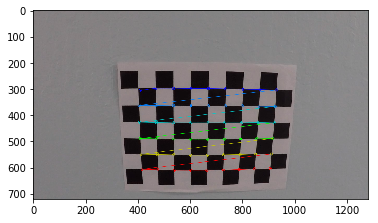

In [192]:
c.calibrate(image.read_dir('./camera_cal'), 9, 6, display=True)

In [188]:
ls = [f for f in os.listdir('./camera_cal') if f != "broken"]

In [189]:
images = image.read_dir('./camera_cal')

print('\n'.join([
    str(i) + ' ' + str(f) for i, f in zip(
        [str(i) + ' ' + str(img.shape) for i, img in zip(range(len(images)), images)], 
        ls
    )]
))

0 (720, 1280, 3) calibration18.jpg
1 (720, 1280, 3) calibration12.jpg
2 (720, 1280, 3) calibration10.jpg
3 (720, 1280, 3) calibration20.jpg
4 (721, 1281, 3) calibration15.jpg
5 (720, 1280, 3) calibration13.jpg
6 (720, 1280, 3) calibration6.jpg
7 (721, 1281, 3) calibration7.jpg
8 (720, 1280, 3) calibration14.jpg
9 (720, 1280, 3) calibration9.jpg
10 (720, 1280, 3) calibration2.jpg
11 (720, 1280, 3) calibration3.jpg
12 (720, 1280, 3) calibration19.jpg
13 (720, 1280, 3) calibration16.jpg
14 (720, 1280, 3) calibration11.jpg
15 (720, 1280, 3) calibration8.jpg
16 (720, 1280, 3) calibration17.jpg
